In [1]:
import yaml
import MetaTrader5 as mt5
import pandas as pd
import os
import numpy as np

In [2]:
def max_drawdown(equity_curve, verbose=True):
    # Calcular el running max de la equity curve
    running_max = np.maximum.accumulate(equity_curve)
    
    # Calcular el drawdown
    drawdown = (equity_curve - running_max) / running_max
    
    # Encontrar el valor máximo de drawdown y la fecha correspondiente
    max_drawdown_value = np.min(drawdown) * 100  # Convertir el drawdown a porcentaje
    max_drawdown_date = equity_curve.index[np.argmin(drawdown)]
    
    if verbose:
        print(f"Máximo drawdown: {max_drawdown_value:.2f}%")
        print(f"Fecha del máximo drawdown: {max_drawdown_date}")

    return max_drawdown_value

In [3]:
INITIAL_CASH = 10_000

candidates = (
    'BbandsCross_GBPUSD_16385', 
    'BbandsCross_USDCHF_16386', 
    'BPercent_EURUSD_16386',
    'ShortIBS_EURUSD_16387',
)

In [4]:
pd.set_option('display.max_columns', 500) # number of columns to be displayed


if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

root = './backbone/data'

with open('configs/live_trading.yml', 'r') as file:
    strategies = yaml.safe_load(file)

timeframes_to_number = {
    'H1': 16385,
    'H2': 16386,
    'H3': 16387,
    'H4': 16388,
}

equity_curves = {}

for strategy_name, configs in strategies.items():
    
    instruments_info = configs['instruments_info']
    wfo_params = configs['wfo_params']
    opt_params = configs['opt_params']
    name = strategy_name.split('.')[-1]
    use_wfo = wfo_params['use_wfo']
    
    
    root =  os.path.join('./backtesting_pipeline/strategies', name)
    
    if use_wfo:
        dir = os.path.join(root, 'full_analysis')
    
    else:
        dir = os.path.join(root, 'preliminar_analysis')
        
    for ticker, info in instruments_info.items():
        timeframe = timeframes_to_number[info['timeframe']]
        key = f'{ticker}_{timeframe}'
        
        full_key = f'{name}_{ticker}_{timeframe}'
        
        if full_key in candidates:
            future_equity = pd.read_csv(
                os.path.join(dir, key, 'equity.csv'), index_col=0
            )
            future_equity.index = pd.to_datetime(future_equity.index)
            
            equity_curves[full_key] = future_equity

In [5]:
equity_curves.keys()

dict_keys(['BbandsCross_GBPUSD_16385', 'BbandsCross_USDCHF_16386', 'BPercent_EURUSD_16386', 'ShortIBS_EURUSD_16387'])

In [6]:
import pandas as pd

min_date = None
max_date = None

for name, curve in equity_curves.items():
    # Convertir las fechas a UTC si son tz-naive
    actual_date = curve.index[0].tz_localize('UTC') if curve.index[0].tz is None else curve.index[0].tz_convert('UTC')
    
    # Si min_date es None, inicializar con la primera fecha
    if min_date is None:
        min_date = actual_date
    # Comparar si la fecha actual es menor que min_date
    elif actual_date < min_date:
        min_date = actual_date

    # Si max_date es None, inicializar con la última fecha
    curve_last_date = curve.index[-1].tz_localize('UTC') if curve.index[-1].tz is None else curve.index[-1].tz_convert('UTC')
    
    if max_date is None:
        max_date = curve_last_date
    # Comparar si la fecha actual es mayor que max_date
    elif curve_last_date > max_date:
        max_date = curve_last_date

# Mostrar las fechas encontradas
print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")

# Calcular min_date y max_date
min_date = min_date.date()
max_date = max_date.date()

print(min_date)
print(max_date)

date_range = pd.to_datetime(pd.date_range(start=min_date, end=max_date, freq='D'))
print(date_range)

Min Date: 2021-01-04 00:00:00+00:00
Max Date: 2024-11-01 00:00:00+00:00
2021-01-04
2024-11-01
DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11',
               '2021-01-12', '2021-01-13',
               ...
               '2024-10-23', '2024-10-24', '2024-10-25', '2024-10-26',
               '2024-10-27', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01'],
              dtype='datetime64[ns]', length=1398, freq='D')


In [7]:

def get_hipotetical_wallet_equity(equity_curves, initial_equity):
    total = pd.DataFrame()

    for name, curve in equity_curves.items():
        eq = curve.copy()
        eq = eq.reset_index().rename(columns={'index':'Date'})[['Date','Equity']].sort_values(by='Date')
        eq['Date'] = pd.to_datetime(eq['Date'])
        eq['Date'] = eq['Date'].dt.floor('D').dt.date

        eq = eq.groupby('Date').agg({'Equity':'last'})

        eq = eq.reindex(date_range)
        
        eq.Equity = eq.Equity.ffill()
        eq.Equity = eq.Equity.fillna(INITIAL_CASH)
    
        eq['variacion'] = eq['Equity'] - eq['Equity'].shift(1)
        eq['variacion_porcentual'] = eq['variacion'] / eq['Equity'].shift(1)
        
        df_variacion = pd.DataFrame(
            {
                f'variacion_{name}': eq.variacion_porcentual.fillna(0)
            }
        )
        
        total = pd.concat([total, df_variacion], axis=1)

    total = total.reset_index().rename(columns={'index':'Date'})

    # Inicializa el valor de equity
    total['Equity'] = initial_equity

    # Lista de columnas con las variaciones porcentuales
    variation_cols = [col for col in total.columns if col.startswith('variacion')]

    # Calcular la curva de equity
    for i in range(1, len(total)):
        previous_equity = total.loc[i-1, 'Equity']  # Equity del periodo anterior
        
        # Calcula el impacto monetario de cada bot por separado y suma el resultado
        impact_sum = 0
        for col in variation_cols:
            variation = total.loc[i, col]
            impact_sum += previous_equity * variation
        
        # Actualiza el equity sumando el impacto monetario total
        total.loc[i, 'Equity'] = previous_equity + impact_sum

    # Resultado final

    total = total.set_index('Date')
    return total[['Equity']]

if 'variaciones_porcentuales' in equity_curves.keys():
    del equity_curves['variaciones_porcentuales']

total = get_hipotetical_wallet_equity(equity_curves=equity_curves, initial_equity=INITIAL_CASH)
equity_curves['variaciones_porcentuales'] = total

In [9]:
import plotly.graph_objects as go

# Crear una figura vacía
fig = go.Figure()

# Recorrer las curvas de equity de cada bot y agregarlas al gráfico
for k, v in equity_curves.items():
    
    fig.add_trace(go.Scatter(x=v.index, y=v.Equity, mode='lines', name=k))

# Actualizar los detalles del layout del gráfico
fig.update_layout(
    title="Curvas de Equity de Múltiples Bots",
    xaxis_title="Fecha",
    yaxis_title="Equity",
    legend_title="Bots"
)

# Mostrar el gráfico
fig.show()

max_drawdown(equity_curves['variaciones_porcentuales'])


Máximo drawdown: -9.67%
Fecha del máximo drawdown: 2024-01-04 00:00:00


-9.672683839592

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px

# Supongamos que tienes el DataFrame `df` como en el ejemplo
# Convertir el índice a tipo datetime si no lo está
df = equity_curves["variaciones_porcentuales"]
df.index = pd.to_datetime(df.index)

# Calcular los retornos diarios en porcentaje
df['Daily Return'] = ((df['Equity'] - df['Equity'].shift(1)) / df['Equity'].shift(1)) * 100

# Crear un DataFrame resampleado con valores mínimo y máximo para cada mes
monthly_min = df['Daily Return'].resample("M").min()
monthly_max = df['Daily Return'].resample("M").max()

# Aplicar la lógica de np.where para seleccionar el mínimo si < 0, máximo si >= 0
monthly_returns = np.where(monthly_max >= 0, monthly_max, monthly_min)

# Crear un índice temporal basado en las fechas de los datos mensuales
monthly_index = df['Daily Return'].resample("M").apply(lambda x: x.index[-1])

# Crear un DataFrame para el gráfico
monthly_df = pd.DataFrame({
    'Fecha': monthly_index,
    'Retorno Mensual': monthly_returns
})

display(monthly_df)

# Crear el gráfico de barras con Plotly
fig = px.bar(
    monthly_df,
    x='Fecha',
    y='Retorno Mensual',
    labels={"Fecha": "Fecha", "Retorno Mensual": "Retorno Mensual (%)"},
    title="Retornos Mensuales Ajustados en Porcentaje",
    text_auto='.2s'
)

fig.update_layout(
    # width=800,
    # height=700,
    xaxis_title="Fecha",
    yaxis_title="Retorno Mensual (%)",
    xaxis=dict(tickformat="%Y-%m"),
)

fig.show()


,Fecha,Retorno Mensual
Date,,
2021-01-31,2021-01-31,0.402962
2021-02-28,2021-02-28,0.466526
2021-03-31,2021-03-31,3.165772
2021-04-30,2021-04-30,0.569248
2021-05-31,2021-05-31,1.324100
2021-06-30,2021-06-30,1.612153
2021-07-31,2021-07-31,2.797812
2021-08-31,2021-08-31,1.631411
2021-09-30,2021-09-30,2.162137


In [11]:
del equity_curves['variaciones_porcentuales']

# FTMO Simulator

In [12]:
def ftmo_simulator(equity_curve, initial_cash):
    equity_curve['month'] = pd.to_datetime(equity_curve.index)
    equity_curve['month'] = pd.to_datetime(equity_curve['month'], errors='coerce')  # Asegúrate de que sea datetime
    equity_curve['month'] = equity_curve['month'].dt.to_period('M')  # Convertir a un periodo mensual
    
    equity_curve.fillna(0, inplace=True)

    # Identificar índices de los valores máximo y mínimo por mes
    max_indices = equity_curve.groupby('month')['Equity'].idxmax()
    min_indices = equity_curve.groupby('month')['Equity'].idxmin()

    # Combinar índices únicos
    unique_indices = pd.Index(max_indices).union(pd.Index(min_indices))

    equity_curve = equity_curve.loc[unique_indices]
    
    # Inicializar acumuladores globales
    total_positive_hits = 0
    total_negative_hits = 0
    all_time_to_positive = []
    all_time_to_negative = []

    # Simulación para cada mes como punto de partida
    for i in range(0, len(equity_curve), 2):
        perc_change = 0
        time_to_positive = []
        time_to_negative = []
        
        actual_equity = equity_curve.iloc[i].Equity
        
        months_elapsed = 0

        # Iterar desde el mes de inicio hacia adelante
        for j in range(i, len(equity_curve)):
            
            future_equity = equity_curve.iloc[j].Equity
            
            if i == 0 and j == 0:
                perc_change = ((future_equity - initial_cash) / initial_cash) * 100
                
            else:
                perc_change = ((future_equity - actual_equity) / actual_equity) * 100
            
            months_elapsed += 0.5

            if perc_change >= 10:
                total_positive_hits += 1
                time_to_positive.append(months_elapsed)
                months_elapsed = 0
                break

            elif perc_change <= -10:
                total_negative_hits += 1
                time_to_negative.append(months_elapsed)
                months_elapsed = 0
                break

        # Guardar tiempos de esta simulación
        all_time_to_positive.extend(time_to_positive)
        all_time_to_negative.extend(time_to_negative)

    return total_positive_hits, total_negative_hits, all_time_to_positive, all_time_to_negative


In [13]:
# ftmo_simulator(equity_curves['variaciones_porcentuales'], 10_000)

In [14]:
from itertools import combinations

# Generar todas las combinaciones de las claves del diccionario
keys = list(equity_curves.keys())

equity_curves_combinations = []

# Obtenemos combinaciones desde tamaño 1 hasta len(keys)
for r in range(2, len(keys) + 1):
    for combination in combinations(keys, r):
        equity_curves_combinations.append(combination)

equity_curves_combinations

[('BbandsCross_GBPUSD_16385', 'BbandsCross_USDCHF_16386'),
 ('BbandsCross_GBPUSD_16385', 'BPercent_EURUSD_16386'),
 ('BbandsCross_GBPUSD_16385', 'ShortIBS_EURUSD_16387'),
 ('BbandsCross_USDCHF_16386', 'BPercent_EURUSD_16386'),
 ('BbandsCross_USDCHF_16386', 'ShortIBS_EURUSD_16387'),
 ('BPercent_EURUSD_16386', 'ShortIBS_EURUSD_16387'),
 ('BbandsCross_GBPUSD_16385',
  'BbandsCross_USDCHF_16386',
  'BPercent_EURUSD_16386'),
 ('BbandsCross_GBPUSD_16385',
  'BbandsCross_USDCHF_16386',
  'ShortIBS_EURUSD_16387'),
 ('BbandsCross_GBPUSD_16385',
  'BPercent_EURUSD_16386',
  'ShortIBS_EURUSD_16387'),
 ('BbandsCross_USDCHF_16386',
  'BPercent_EURUSD_16386',
  'ShortIBS_EURUSD_16387'),
 ('BbandsCross_GBPUSD_16385',
  'BbandsCross_USDCHF_16386',
  'BPercent_EURUSD_16386',
  'ShortIBS_EURUSD_16387')]

In [15]:

from sklearn.linear_model import LinearRegression

stability_ratio = 0
best_ratio = 0

results = pd.DataFrame()

for combination in equity_curves_combinations:
    selected_curves = {}
    for name in combination:
        selected_curves[name] = equity_curves[name]
    
    # Generar la curva combinada
    combined_equity = get_hipotetical_wallet_equity(selected_curves, initial_equity=INITIAL_CASH)
    
    # Calcular métricas como retorno y drawdown
    x = np.arange(len(combined_equity)).reshape(-1, 1)
    reg = LinearRegression().fit(x, combined_equity)
    stability_ratio = reg.score(x, combined_equity)
    
    return_ = ((combined_equity.Equity.iloc[-1] - combined_equity.Equity.iloc[0]) / combined_equity.Equity.iloc[0]) * 100
    dd = -1 * max_drawdown(combined_equity, verbose=False)
    
    positive_hits, negative_hits, time_to_positive, time_to_negative = ftmo_simulator(combined_equity, INITIAL_CASH)

    combination_results = pd.DataFrame({
        'combination':[combination],
        'stability_ratio':[stability_ratio],
        'return':[return_],
        'drawdown':[dd],
        'ret_drawdown':[return_/dd],
        
        'success':[positive_hits / (positive_hits + negative_hits)],
        'positive_hits':[positive_hits],
        'negative_hits':[negative_hits],
        'mean_time_to_positive':[np.mean(time_to_positive)],
        'std_time_to_positive':[np.std(time_to_positive)],
        'mean_time_to_negative':[np.mean(time_to_negative)],
        'std_time_to_negative':[np.std(time_to_negative)],
        
    })

    results = pd.concat([results, combination_results])
    
results.sort_values(by='ret_drawdown', ascending=False)

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning:

invalid value encountered in divide

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\numpy\core\fromnume

,combination,stability_ratio,return,drawdown,ret_drawdown,success,positive_hits,negative_hits,mean_time_to_positive,std_time_to_positive,mean_time_to_negative,std_time_to_negative
0,"(BbandsCross_GBPUSD_16385, BbandsCross_USDCHF_...",0.939380,130.376868,9.672684,13.478872,1.000,39,0,4.346154,2.072883,NaN,NaN
0,"(BbandsCross_GBPUSD_16385, BbandsCross_USDCHF_...",0.950624,79.992273,6.239361,12.820587,1.000,40,0,7.612500,3.854360,NaN,NaN
0,"(BbandsCross_GBPUSD_16385, ShortIBS_EURUSD_16387)",0.962472,62.927927,6.250240,10.068081,1.000,38,0,8.210526,3.677155,NaN,NaN
0,"(BbandsCross_GBPUSD_16385, BPercent_EURUSD_163...",0.944314,108.777232,11.207600,9.705667,0.975,39,1,4.730769,2.168676,5.0,0.0
0,"(BbandsCross_GBPUSD_16385, BbandsCross_USDCHF_...",0.942988,81.577572,8.679962,9.398379,1.000,38,0,6.263158,3.100800,NaN,NaN
0,"(BbandsCross_USDCHF_16386, BPercent_EURUSD_163...",0.924096,79.941997,8.608818,9.286060,1.000,33,0,6.590909,3.536508,NaN,NaN
0,"(BbandsCross_GBPUSD_16385, BbandsCross_USDCHF_...",0.945713,41.644606,5.029361,8.280298,1.000,37,0,11.054054,4.473320,NaN,NaN
0,"(BbandsCross_GBPUSD_16385, BPercent_EURUSD_16386)",0.947370,64.574780,9.651796,6.690442,1.000,36,0,6.541667,3.492800,NaN,NaN
0,"(BbandsCross_USDCHF_16386, ShortIBS_EURUSD_16387)",0.891331,40.425549,6.311103,6.405465,1.000,32,0,11.890625,5.580007,NaN,NaN
0,"(BPercent_EURUSD_16386, ShortIBS_EURUSD_16387)",0.918383,63.073138,9.980790,6.319453,1.000,32,0,6.390625,2.879709,NaN,NaN


In [15]:
# results.to_csv('./wallet_results.csv')

In [16]:

0/0

ZeroDivisionError: division by zero

In [16]:
# ShortIBS_ADAUSD_H4 = equity_curves['ShortIBS_ADAUSD_H4']
# ShortIBS_DOTUSD_H4 = equity_curves['ShortIBS_DOTUSD_H4']
# TripleST_NVDA_H4 = equity_curves['TripleST_NVDA_H4']
# MeanRev_XMRUSD_H4 = equity_curves['MeanRev_XMRUSD_H1']

# del equity_curves['TripleST_NVDA_H4']
# del equity_curves['TripleSMA_US100.cash_H2']
# del equity_curves['TripleST_TSLA_H3']


# del equity_curves['MeanRev_XMRUSD_H1']


# equity_curves['ShortIBS_ADAUSD_H4'] = ShortIBS_ADAUSD_H4
# equity_curves['ShortIBS_DOTUSD_H4'] = ShortIBS_DOTUSD_H4
# equity_curves['TripleST_NVDA_H4'] = TripleST_NVDA_H4
# equity_curves['MeanRev_XMRUSD_H4'] = MeanRev_XMRUSD_H4

# Correlaciones

In [16]:
percentual_differences = {}

def get_percentual_differences(equity_curves):
    for name, curve in equity_curves.items():
        equity_df = curve.copy()
        
        equity_df = equity_df.reset_index().rename(columns={'index':'Date'})
        equity_df['Date'] = pd.to_datetime(equity_df['Date'])
        equity_df['Date'] = equity_df['Date'].dt.floor('D').dt.date
        
        equity_df = pd.DataFrame(equity_df.groupby('Date')['Equity'].last()).reindex(date_range)
        equity_df.ffill(inplace=True)
        equity_df.fillna(INITIAL_CASH, inplace=True)

        equity_df['diff'] = equity_df['Equity'] - equity_df['Equity'].shift(1)
        
        percentual_differences[name] = equity_df
    
    return percentual_differences


differences = get_percentual_differences(equity_curves)
differences

{'BbandsCross_GBPUSD_16385':                   Equity       diff
 2021-01-04  10000.000000        NaN
 2021-01-05  10000.000000   0.000000
 2021-01-06  10000.000000   0.000000
 2021-01-07  10000.000000   0.000000
 2021-01-08  10000.000000   0.000000
 ...                  ...        ...
 2024-10-28  12825.030390  60.951729
 2024-10-29  12825.030390   0.000000
 2024-10-30  12766.465738 -58.564651
 2024-10-31  12823.245738  56.780000
 2024-11-01  12823.245738   0.000000
 
 [1398 rows x 2 columns],
 'BbandsCross_USDCHF_16386':                   Equity       diff
 2021-01-04  10000.000000        NaN
 2021-01-05  10000.000000   0.000000
 2021-01-06  10000.000000   0.000000
 2021-01-07  10000.000000   0.000000
 2021-01-08  10000.000000   0.000000
 ...                  ...        ...
 2024-10-28  11051.796356  -5.166624
 2024-10-29  11082.386356  30.590000
 2024-10-30  11082.386356   0.000000
 2024-10-31  11049.713587 -32.672769
 2024-11-01  11045.803587  -3.910000
 
 [1398 rows x 2 columns],


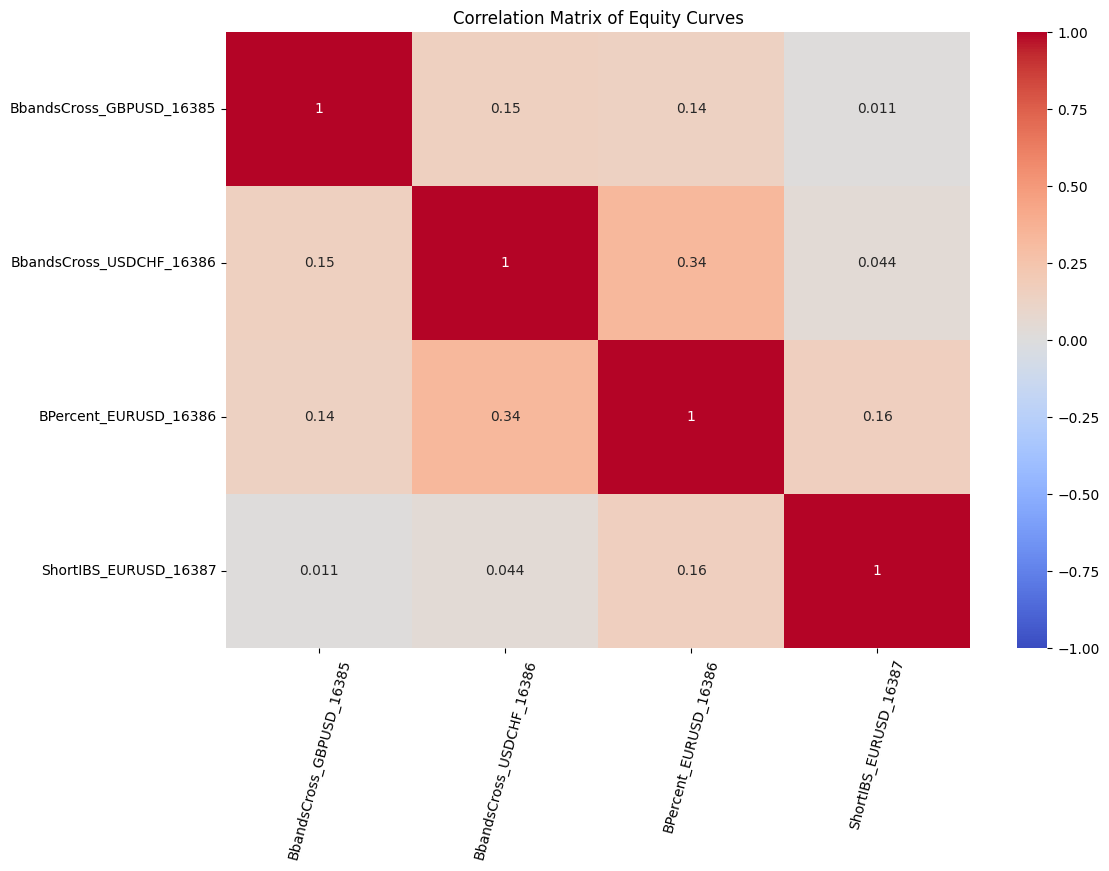

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in differences.items():
    all_equity_df[name] = df.resample('M').agg({'Equity':'last','diff':'sum',})['diff']


# Paso 2: Calcular la matriz de correlación

# all_equity_df = all_equity_df[['BPercent_IQm_H1','BPercent_NTESm_H1']]
correlation_matrix = all_equity_df.corr(method='pearson')

# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=75)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Unir todas las curvas de equity en un solo DataFrame basado en la fecha
all_equity_df = pd.DataFrame()

for name, df in differences.items():
    all_equity_df[name] = df.resample('W').agg({'Equity':'last','diff':'sum',})['diff']


# Paso 2: Calcular la matriz de correlación

# all_equity_df = all_equity_df[['BPercent_IQm_H1','BPercent_NTESm_H1']]
correlation_matrix = all_equity_df.corr(method='pearson')

# Paso 3: Plotear el mapa de calor de correlación usando seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Equity Curves')
plt.xticks(rotation=75)
plt.show()